# INCAWrapper validation case medium size model
In this notebook, we use the INCAWrapper to fit a simulated data. This notebook serves as an integration test the INCAWrapper that can be run when changes are made to the codebase to ensure that the INCAWrapper performs consistently. Furthermore, this case act as a validation case the show that the INCAWrapper actually works and that it is capable of estimating correct flux distribution from simulated data.

This notebook is NOT meant as a tutorial and therefore code description is a bit more sparse. For a proper tutorial see examples page in the documentation (https://incawrapper.readthedocs.io/en/latest/examples/index.html).

The model we use is from Alagesan, S., Minton, N.P. & Malys, N. 13C-assisted metabolic flux analysis to investigate heterotrophic and mixotrophic metabolism in Cupriavidus necator H16. Metabolomics 14, 9 (2018). https://doi.org/10.1007/s11306-017-1302-z, which is also used for one of the tutorials.

The simulation mimics a single experiment where C. necator is grown with labelled frucotse and unlabelled glycerol. We simulated MS measurements of the amino acids and a few exchanges fluxes are measured. To increase the information about the systems we simulate measurements of CO2 exchange flux. To do this we added one additional reaction to the original model, i.e. CO2 -> CO2.ext. For more details about the simulation see the [simulation script](../docs/examples/Literature%20data/Cupriavidus%20necator%20%20Alagesan%202017/c_necator_simulation.py).

In [1]:
import pandas as pd
import numpy as np
import dotenv
import ast
import pandera as pa
import incawrapper
from incawrapper import utils
from incawrapper import visualization
import pathlib
import matplotlib.pyplot as plt
import pytest

In [2]:
# import environment variables
INCA_base_directory = dotenv.get_key(dotenv.find_dotenv(), "INCA_base_directory")

In [3]:
# set up path to data
working_dir = pathlib.Path(dotenv.find_dotenv()).parent
data_directory = working_dir / 'docs' / 'examples' / 'Literature data' / 'Cupriavidus necator  Alagesan 2017' / 'simulated_data'
results_file = data_directory / 'fit_simulated_fructose.mat'

In [4]:
# Reading the reactions, tracers, and simulated measurements
rxn = pd.read_csv(data_directory / 'reactions_processed.csv')
tracers = pd.read_csv(
    data_directory / 'tracer_info.csv', 
    converters={"atom_ids": ast.literal_eval, "atom_mdv": ast.literal_eval}
)
flux_measurements = pd.read_csv(data_directory / 'flux_measurements_no_noise.csv')
mdv_measurements = pd.read_csv(
    data_directory / 'mdv_no_noise.csv',
    converters={"labelled_atom_ids": ast.literal_eval}
)

In [5]:
rxn

,rxn_id,rxn_eqn
0,ex_1,FRU.ext (abcdef) -> F6P (abcdef)
1,ex_2,GLY.ext (abc) -> GLY (abc)
2,R1,GLY (abc) -> DHAP (abc)
3,R2,F6P (abcdef) <-> G6P (abcdef)
4,R4,F16P (abcdef) -> F6P (abcdef)
5,R5,F16P (abcdef) <-> DHAP (cba) + G3P (def)
6,R7,DHAP (abc) <-> G3P (abc)
7,R9,G3P (abc) <-> 3PG (abc)
8,R11,3PG (abc) <-> PEP (abc)
9,R13,PEP (abc) <-> PYR (abc)


In [6]:
flux_measurements

,rxn_id,flux,experiment_id,flux_std_error
0,R72,22.041446,fructose,0.066124
1,ex_1,100.000000,fructose,0.300000
2,ex_2,127.011126,fructose,0.381033
3,ex_3,108.817801,fructose,0.326453


In [7]:
script = incawrapper.create_inca_script_from_data(
    reactions_data=rxn,
    tracer_data=tracers,
    flux_measurements=flux_measurements,
    ms_measurements=mdv_measurements,
    experiment_ids=["fructose"],
)
# script.add_to_block(
#     "model_modifications",
#     incawrapper.modify_class_instance(
#         class_name="states",
#         sub_class_name=None,
#         instance_id="CO2",
#         properties={"bal": False},
#     )
# )
script.add_to_block(
    "options",
    incawrapper.define_options(
        fit_starts=50,
        sim_ss=True,
        sim_na=True,
        sim_more=True,
    )
)
script.add_to_block(
    "runner",
    incawrapper.define_runner(
        output_filename=results_file,
        run_estimate=True,
        run_continuation=True,
        run_simulation=True,
    )
)

In [8]:
incawrapper.run_inca(
    inca_script=script,
    INCA_base_directory=INCA_base_directory,
)

INCA script saved to /var/folders/z6/mxpxh4k56tv0h0ff41vmx7gdwtlpvp/T/tmpf6b5_4mz/inca_script.m.
Starting MATLAB engine...
 
ms_fructose = 1x23 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
Alanine232 Alanine260 Asparticacid302 Asparticacid390 Asparticacid418 Glutamicacid330 Glutamicacid432 Glycine218 Glycine246 Histidine338 Histidine440 Isoleucine274 Leucine274 Methionine320 Phenylalanine302 Phenylalanine308 Phenylalanine336 Serine362 Serine390 Threonine376 Threonine404 Valine260 Valine288
 
 
ms_fructose = 1x23 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
Alanine232 Alanine260 Asparticacid302 Asparticacid390 Asparticacid418 Glutamicacid330 Glutamicacid432 Glycine218 Glycine246 Histidine338 Histidine440 Isoleucine274 Leucine274 Methionine320 Phenylalanine302 Phenylalanine308 Phenylalanine336 Serine362 Serine390 Threonine376 Threonine404 Valine260 Valine288
 
 
ms_fructose = 1x23 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
Alanine23

Now we can read in the fit and validate that the INCAWrapper was able to find the true simulated fluxes. 

In [9]:
# read in the fitted fluxes
res = incawrapper.INCAResults(results_file)

# get the goodness of fit
res.fitdata.get_goodness_of_fit()

Fit accepted: False
Confidence level: 0.05
Chi-square value (SSR): 0.004816710752551555
Expected chi-square range: [17.53873858 48.23188959]


The SSR is very small which indicate over-fitting, however this is expected because this is simulated data without any measurement error or bias'.

We can now load the true flux distribution and compare the to fitted. The true (simulated) flux distribution has some very small values, these are rounded as they cause some issues in the comparison.

In [10]:
true_fluxes = pd.read_csv(data_directory / 'true_fluxes.csv').round(6)

In [11]:
# combines the fitted and true fluxes
true_and_fitted_fluxes = pd.merge(
    res.fitdata.fitted_parameters.query("type.str.contains('flux')"),
    true_fluxes.rename(columns={"rxn_id": "id", "flux": "val"}),
    on="id",
    suffixes=("_fitted", "_true"),
)

INCA is not able to make an exact match to the true fluxes because there are to few measurements. Therefore, we will check fraction of the true fluxes are within the estimated upper and lower bounds.

In [12]:
def is_in_interval(x, lb, ub):
    return (x >= lb) & (x <= ub)

# few tests to validate function
assert is_in_interval(4.5,-np.inf,10) == True
assert is_in_interval(4.5,0,10) == True
assert is_in_interval(10,0,4.5) == False

true_vals_in_interval = true_and_fitted_fluxes.apply(
    lambda x: is_in_interval(x['val_true'], x['lb'], x['ub']), axis=1
)

fraction_correct_fluxes = true_vals_in_interval.sum() / true_vals_in_interval.size
fraction_correct_fluxes

0.9733333333333334

We can also vizualize the fitted and true fluxes. Note that some fluxes have very large bounds, we these are truncated for visualization purposes.

(-250.0, 400.0)

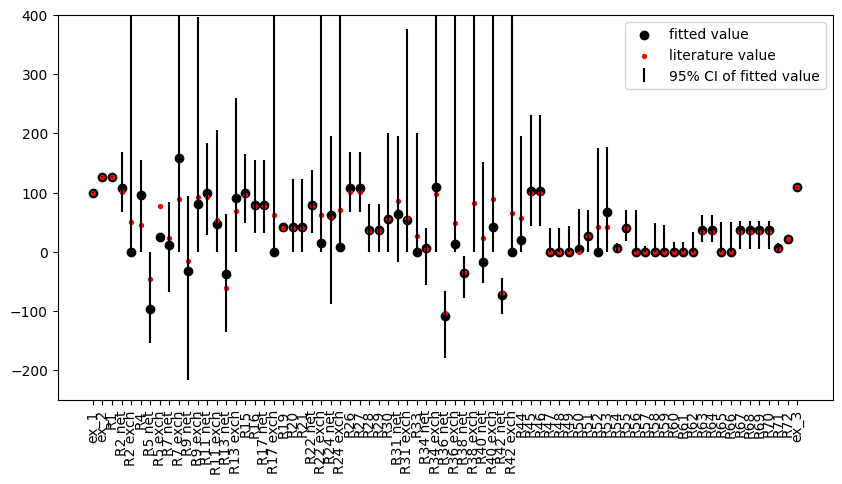

In [13]:
yaxis_range = [-250, 400]
plot_df = true_and_fitted_fluxes.copy()
# replace inf with large number
plot_df['lb'].replace(np.inf, yaxis_range[0], inplace=True)
plot_df['ub'].replace(np.inf, yaxis_range[1], inplace=True)
fig, ax = plt.subplots(figsize=(10, 5))
errbars = plot_df[['lb', 'ub']].subtract(plot_df['val_fitted'], axis=0).abs().T
ax.scatter(x=plot_df['id'], y=plot_df['val_fitted'], color='black', label='fitted value')
ax.errorbar(x=plot_df['id'], y=plot_df['val_fitted'], yerr=errbars, color='black', fmt='none', label='95% CI of fitted value')
ax.scatter(x=plot_df['id'], y=plot_df['val_true'], color='red', label='literature value', s=8)
# rotate x-axis labels
ax.tick_params(axis='x', labelrotation=90)
ax.legend()
ax.set_ylim(yaxis_range)

Finally, we will compare inspect the fluxes which where not within the estimated interval.

In [14]:
true_and_fitted_fluxes[~true_vals_in_interval]

,type,id,eqn,val_fitted,std,lb,ub,unit,free,alf,chi2s,cont,cor,cov,vals,base,val_true
7,Exch flux,R5 exch,F16P <-> DHAP + G3P,25.675548,10312.567000,0,NaN,[],1,0.05,"[0.004816710072503681, 0.004816710752551555, 0...",1,"[-1.479209225137343e-05, 9.146520951974e-07, 9...","[-0.04576334671534951, 0.0035940762829684827, ...","[0.0, 25.67554776522942, 25.67554776522942, 40...",{'id': []},76.941910
20,Net flux,R19,ISCIT -> AKG + CO2,42.339669,156.177351,NaN,132.609232,[],1,0.05,"[2.7623863374470483, 2.7276012311514055, 2.727...",1,"[-0.0021806557716092154, 0.0020189197268046877...","[-0.10217074351379705, 0.12014388645242147, 0....","[5.296665430073243e-06, 5.298588252882966e-06,...",{'id': []},40.782327


All these fluxes has Nan as one o

In [17]:
## Setup validation tests that test that the results are similar to the previous run
# Test that the fraction of correct fluxes similar to ealier run
assert fraction_correct_fluxes == pytest.approx(0.97, 0.005)

# Test that the chi2 is similar to ealier run, this test may be fragile because the flux 
# estimation is stochastic. Therefore, we only test that the chi2 very small (i.e. < 1).
assert res.fitdata.chi2 < 0.1

In [28]:
def well_determined_fluxes(val, lb, ub, cutoff):
    '''Finds well defined fluxes, these are fluxes were the relative uncertainty span is less than the cutoff'''
    if val == 0:
        return (ub - lb) < cutoff
    relative_uncertainty_span = (ub - lb) / np.abs(val)
    return relative_uncertainty_span < cutoff

assert well_determined_fluxes(1, 0.9, 1.1, 0.21) == True
assert well_determined_fluxes(1, 0.9, 1.1, 0.1) == False

In [30]:
true_and_fitted_fluxes['well_determined'] = true_and_fitted_fluxes.apply(
    lambda x: well_determined_fluxes(x['val_true'], x['lb'], x['ub'], 1), axis=1
)
true_and_fitted_fluxes[true_and_fitted_fluxes['well_determined']]

,type,id,eqn,val_fitted,std,lb,ub,unit,free,alf,chi2s,cont,cor,cov,vals,base,val_true,well_determined
0,Net flux,ex_1,FRU.ext -> F6P,99.999982,0.300000,99.411585,100.588369,[],0,0.05,"[4.165258187414408, 3.564766079278992, 2.79647...",0,"[0.9999999999999998, 3.155331314184475e-07, 3....","[0.0900000550358148, 3.606873648534564e-08, 3....","[99.38775591981968, 99.43360994142073, 99.4983...",{'id': []},100.000000,True
1,Net flux,ex_2,GLY.ext -> GLY,127.011140,0.381035,126.264054,127.757948,[],0,0.05,"[4.611818183463812, 3.843524855963739, 3.07523...",0,"[3.183761946857657e-06, 1.0, 1.0, -0.004954620...","[3.639372834702141e-07, 0.14518747348736127, 0...","[126.19304176032938, 126.26432199202944, 126.3...",{'id': []},127.011126,True
2,Net flux,R1,GLY -> DHAP,127.011140,0.381035,126.264054,127.757948,[],0,0.05,"[4.611818183463812, 3.843524855963739, 3.07523...",0,"[3.183761946857657e-06, 1.0, 1.0, -0.004954620...","[3.639372834702141e-07, 0.14518747348736127, 0...","[126.19304176032938, 126.26432199202944, 126.3...",{'id': []},127.011126,True
3,Net flux,R2 net,F6P <-> G6P,107.388860,42.095527,67.997473,168.125225,[],0,0.05,"[4.01125566245582, 3.7566454440244224, 2.98376...",0,"[0.012614286780423537, -0.004954614400946524, ...","[0.15930156442707188, -0.07947131286156796, -0...","[67.73356051874133, 68.14933916251516, 69.6320...",{'id': []},100.306119,True
27,Net flux,R26,G6P -> 6PG,107.388860,42.095527,67.997473,168.125225,[],0,0.05,"[4.01125566245582, 3.7566454440244224, 2.98376...",0,"[0.012614286780423537, -0.004954614400946524, ...","[0.15930156442707188, -0.07947131286156796, -0...","[67.73356051874133, 68.14933916251516, 69.6320...",{'id': []},100.306119,True
28,Net flux,R27,6PG -> PYR + G3P,107.388860,42.095527,67.997473,168.125225,[],1,0.05,"[4.01125566245582, 3.7566454440244224, 2.98376...",0,"[0.012614286780423537, -0.004954614400946524, ...","[0.15930156442707188, -0.07947131286156796, -0...","[67.73356051874133, 68.14933916251516, 69.6320...",{'id': []},100.306119,True
43,Net flux,R42 net,E4P + X5P <-> F6P + G3P,-72.138929,45.282102,-105.694042,-44.362347,[],1,0.05,"[3.8683696382944426, 3.1298048642313594, 2.804...",0,"[-0.0013461671035379216, -0.003445640827007333...","[-0.01828718829750682, -0.0594512724512264, -0...","[-105.7267387755753, -104.56503356551899, -104...",{'id': []},-68.801879,True
73,Net flux,R72,ACCOA -> PHB_B,22.041446,0.066126,21.911817,22.171128,[],0,0.05,"[4.131145094821484, 3.3628533307605895, 2.5945...",0,"[2.9715053713408117e-06, -5.635333389440468e-0...","[5.8948028707266954e-08, -1.4198928339975843e-...","[21.90712555498838, 21.920273847931107, 21.935...",{'id': []},22.041446,True
74,Net flux,ex_3,CO2 -> CO2.ext,108.817809,0.326453,108.17761,109.45777,[],1,0.05,"[4.294083401677505, 3.5257916196401555, 3.0736...",0,"[-1.8993126988742533e-07, -8.528342918519029e-...","[-1.8601118415802234e-08, -1.0608413185535176e...","[108.14136630045269, 108.2048681286361, 108.24...",{'id': []},108.817801,True
